<div class="markdown-google-sans">
  <h1>Mining Mastodon for Silent Users</h1>
</div>

Group Name: CSNS

Members:

* [Chan Lee](mailto:cl84@uic.edu)
* [Sang Nguyen](mailto:snguye62@uic.edu)
* [Nancy Pitta](mailto:npitta2@uic.edu)
* [Sidney Mei](mailto:sidney2@uic.edu)



<div class="markdown-google-sans">
  <h2>1. Setup</h2>
</div>

Setup the environment with the necessary packages.

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=bc843f40248e8884663ff635981abf054b2de066a65b3c66b2d3fd2b17b226be
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 36.5 MB of archives.
After this operatio

In [ ]:
!pip install Mastodon.py
!pip install pyclustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 4.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395118 sha256=9a04fa5aaf47ed649e44bf166dd33c3a8b8f89be2e6141d66e9739805ee3883d
  Stored in directory: /root/.cache/pip/wheels/b5/42/97/11eee99f5c1e4fdfc170f0a54f9c9eb195df66edb4cf69f449
Successfully built pyclustering


These are the core packages used to extract and store the user data from the instances.

In [ ]:
import multiprocessing
from mastodon import Mastodon
from tqdm import tqdm
import json
import os

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import functions as f
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, avg
from pyspark.sql.types import IntegerType

In [ ]:
from pyspark.ml.feature import VectorAssembler, VectorSlicer, StandardScaler, MinMaxScaler, RobustScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from sklearn.metrics import calinski_harabasz_score, silhouette_score

<div class="markdown-google-sans">
  <h2>2. Data Collection</h2>
</div>

`api_base_urls` contains a list of four URLs, representing the four instances that we will be accessing.

In [ ]:
api_base_urls = [
  'https://mastodon.social',
  'https://mstdn.social',
  'https://mas.to',
  'https://techhub.social',
]

Store the clients so we can access the instances later

In [ ]:
instances = []

for api_base_url in api_base_urls:
  # Create a new application with the user-defined scopes
  client_id, client_secret = Mastodon.create_app(
      'csnsapp',
      scopes=['read'],
      api_base_url=api_base_url,
  )

  # Create a new wrapper with the client
  mastodon = Mastodon(
    client_id,
    client_secret,
    api_base_url=api_base_url,
  )

  instances.append(mastodon)

The get_user_info function retrieves the account information for a user with the specified ID on the specified instance.

In [ ]:
def get_user_info(instance, user_id):
  try:
    # Gather metrics for the current user
    account = instance.account(user_id)

    return {
        'id': account['id'],
        'bot': account['bot'],
        'silenced': account.get('silenced', False),
        'locked': account.get('silenced', False),
        'created_at': account['created_at'],
        'last_status_at': account.get('last_status_at', None),
        'statuses_count': account['statuses_count'],
        'followers_count': account['followers_count'], 
        'following_count': account['following_count'],
    }
  except Exception as e:
    return None # could not get an account for the user_id


Creates a local text file containing the account information for up to 100,000 users in a given instance.

A `pbar` is provided to visualize the collection progress.

In [ ]:
def get_user_data(url, instance, file_name, num_users=100000):
  id = 0

  pbar = tqdm(total=num_users, desc=url)

  # Check if data already exists inside the file
  if os.path.exists(file_name):
    with open(file_name, 'r') as f:
      # attempt to start off where we previously ended
      users = f.readlines()

      last_user = users[-1] if users else None

      if last_user is not None:
        id = int(last_user.split('\t')[0]) + 1
        pbar.n = len(users)

  # use the `tqdm` package to show the progression
  while pbar.n < num_users:
    user_info = get_user_info(instance, id)

    # Add only data for valid users
    if user_info is not None:
      user_id = user_info.pop('id')

      values = ','.join(str(value) for value in user_info.values())

      with open(file_name, 'a') as f:
        # add the formatted string to the file
        f.write(f"{user_id}\t{values}\n")

      pbar.update(1)

    id += 1
  
  pbar.close()

Create a pool of workers to collect the data for each instance simultaneously.

In [ ]:
# A function to collect the data for each instance
def gather_data(data):
  i, instance = data

  file_name = f'user_data_{i + 1}.txt'

  url = api_base_urls[i]

  get_user_data(url, instance, file_name)

# enumerated = [(i, instance) for i, instance in enumerate(instances)]

# # Simultaneously collect the data for each instance
# with multiprocessing.Pool() as pool:
#   pool.map(gather_data, enumerated)

<div class="markdown-google-sans">
  <h2>3. Data Preprocessing</h2>
</div>

The files from the previous stage are stored in a Google Drive folder that is accessible to anyone from the university (with the link).

The code below uses [PyDrive](https://pythonhosted.org/PyDrive/) to authenticate the current user to access those files This is similar to how it was done in the first homework assignment. If the user does not have permission to access the files, they will need to manually add them to the root directory (i.e. the location of this file).

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Running the cell below will create a local copy of the files for each instance. This data was collected from April 2nd through April 5th.

In [ ]:
id = '1NMaO9vLxXga2PtO-ACC_nmiNRSt180Xl'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('user_data_1.txt')

id = '11m1z75_nfR2ne1Ooid4vOPgkZucpc3Ga'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('user_data_2.txt')

id = '1hvw2GmwQ4PyCcBy8v1Iux9HfnES1Nf4A'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('user_data_3.txt')

id = '1fiRnjsLDKke9SQlWmubN9b0iI6GUHCpq'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('user_data_4.txt')

In [ ]:
spark = SparkSession.builder.appName("MastodonDataProcessing").getOrCreate()

In [ ]:
# Reading the file
social_data = spark.read.text("user_data_1.txt")
mstdnsocial_data = spark.read.text("user_data_2.txt")
masto_data = spark.read.text("user_data_3.txt")
tech_hub_data = spark.read.text("user_data_4.txt")

Each server data processed separately

In [ ]:
# Table setup
col_names = ['id', 'bot', 'silenced', 'locked', 'created_at', 'last_status_at', 'statuses_count', 'followers_count', 'following_count']
social_data = social_data.withColumn("fields", split(col("value"), "\t|,")) 
social_data = social_data.select([col("fields").getItem(i).alias(col_names[i]) for i in range(len(col_names))])
mstdnsocial_data = mstdnsocial_data.withColumn("fields", split(col("value"), "\t|,")) 
mstdnsocial_data = mstdnsocial_data.select([col("fields").getItem(i).alias(col_names[i]) for i in range(len(col_names))])
masto_data = masto_data.withColumn("fields", split(col("value"), "\t|,")) 
masto_data = masto_data.select([col("fields").getItem(i).alias(col_names[i]) for i in range(len(col_names))])
tech_hub_data = tech_hub_data.withColumn("fields", split(col("value"), "\t|,")) 
tech_hub_data = tech_hub_data.select([col("fields").getItem(i).alias(col_names[i]) for i in range(len(col_names))])

In [ ]:
# Show the original data
social_data.show(3,False)

+---+-----+--------+------+-------------------------+-------------------+--------------+---------------+---------------+
|id |bot  |silenced|locked|created_at               |last_status_at     |statuses_count|followers_count|following_count|
+---+-----+--------+------+-------------------------+-------------------+--------------+---------------+---------------+
|1  |False|False   |False |2016-03-16 00:00:00+00:00|2023-04-03 00:00:00|73522         |305695         |387            |
|2  |False|False   |False |2016-03-16 00:00:00+00:00|2019-05-17 00:00:00|7441          |102            |19             |
|5  |False|False   |False |2016-03-16 00:00:00+00:00|None               |14            |1              |0              |
+---+-----+--------+------+-------------------------+-------------------+--------------+---------------+---------------+
only showing top 3 rows



In [ ]:
# Show the original data
mstdnsocial_data.show(3,False)

+---+-----+--------+------+-------------------------+-------------------+--------------+---------------+---------------+
|id |bot  |silenced|locked|created_at               |last_status_at     |statuses_count|followers_count|following_count|
+---+-----+--------+------+-------------------------+-------------------+--------------+---------------+---------------+
|1  |False|False   |False |2019-11-01 00:00:00+00:00|2023-02-15 00:00:00|87            |4422           |53             |
|2  |False|False   |False |2017-04-03 00:00:00+00:00|2023-04-03 00:00:00|1061          |995            |1503           |
|6  |False|False   |False |2017-05-12 00:00:00+00:00|2023-04-03 00:00:00|9314          |1527           |603            |
+---+-----+--------+------+-------------------------+-------------------+--------------+---------------+---------------+
only showing top 3 rows



In [ ]:
masto_data.show(3,False)

+---+-----+--------+------+-------------------------+-------------------+--------------+---------------+---------------+
|id |bot  |silenced|locked|created_at               |last_status_at     |statuses_count|followers_count|following_count|
+---+-----+--------+------+-------------------------+-------------------+--------------+---------------+---------------+
|1  |False|False   |False |2019-03-28 00:00:00+00:00|2023-04-01 00:00:00|1578          |35951          |0              |
|2  |True |False   |False |2019-03-28 00:00:00+00:00|2020-10-20 00:00:00|3128547       |0              |0              |
|3  |True |False   |False |2019-03-28 00:00:00+00:00|2019-04-19 00:00:00|4961          |0              |0              |
+---+-----+--------+------+-------------------------+-------------------+--------------+---------------+---------------+
only showing top 3 rows



Bot accounts, locked and silent accounts are not taken into consideration as they add no meaning to our problem statement. <br/>
Hence we filter them below. 

In [ ]:
# Reducing the size of created_at and last_status_at substrings as we need only the dates to determine the activity status
social_data = social_data.withColumn('created_at', f.expr('substring(created_at, 0, length(created_at) - 15)'))
social_data = social_data.withColumn('last_status_at', f.expr('substring(last_status_at, 0, length(last_status_at) - 9)'))
mstdnsocial_data = mstdnsocial_data.withColumn('created_at', f.expr('substring(created_at, 0, length(created_at) - 15)'))
mstdnsocial_data = mstdnsocial_data.withColumn('last_status_at', f.expr('substring(last_status_at, 0, length(last_status_at) - 9)'))
masto_data = masto_data.withColumn('created_at', f.expr('substring(created_at, 0, length(created_at) - 15)'))
masto_data = masto_data.withColumn('last_status_at', f.expr('substring(last_status_at, 0, length(last_status_at) - 9)'))

# Replace empty strings with None 
social_data= social_data.withColumn("last_status_at", when(col("last_status_at")=="" ,'2015-12-30').otherwise(col("last_status_at")))
# Replace empty strings with None 
mstdnsocial_data= mstdnsocial_data.withColumn("last_status_at", when(col("last_status_at")=="" ,'2015-12-30').otherwise(col("last_status_at")))
# Replace empty strings with None 
masto_data= masto_data.withColumn("last_status_at", when(col("last_status_at")=="" ,'2015-12-30').otherwise(col("last_status_at")))

def filter_bots_muted_accounts(user_data):
  # Filter bots
  user_data = user_data[user_data['bot']==False]
  # Filtering silenced & locked accounts to have separate thresholds for later use
  # silenced_users = user_data[user_data['silenced']==True]
  # locked_users = user_data[user_data['locked']==True]
  # Regular users that are neither silenced nor locked
  user_data = user_data[user_data['silenced']==False]
  user_data = user_data[user_data['locked']==False]
  return user_data

social_data = filter_bots_muted_accounts(social_data)
mstdnsocial_data = filter_bots_muted_accounts(mstdnsocial_data)
masto_data = filter_bots_muted_accounts(masto_data)

In [ ]:
social_data.show(3,False)

+---+-----+--------+------+----------+--------------+--------------+---------------+---------------+
|id |bot  |silenced|locked|created_at|last_status_at|statuses_count|followers_count|following_count|
+---+-----+--------+------+----------+--------------+--------------+---------------+---------------+
|1  |False|False   |False |2016-03-16|2023-04-03    |73522         |305695         |387            |
|2  |False|False   |False |2016-03-16|2019-05-17    |7441          |102            |19             |
|5  |False|False   |False |2016-03-16|2015-12-30    |14            |1              |0              |
+---+-----+--------+------+----------+--------------+--------------+---------------+---------------+
only showing top 3 rows



In [ ]:
# Converting date from string format to datetime format
func =  udf (lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'), DateType())
social_data = social_data.withColumn('created_at', func(col('created_at')))
mstdnsocial_data = mstdnsocial_data.withColumn('created_at', func(col('created_at')))
masto_data = masto_data.withColumn('created_at', func(col('created_at')))
social_data = social_data.withColumn('last_status_at', func(col('last_status_at')))
mstdnsocial_data = mstdnsocial_data.withColumn('last_status_at', func(col('last_status_at')))
masto_data = masto_data.withColumn('last_status_at', func(col('last_status_at')))
social_data.show(2, False)

+---+-----+--------+------+----------+--------------+--------------+---------------+---------------+
|id |bot  |silenced|locked|created_at|last_status_at|statuses_count|followers_count|following_count|
+---+-----+--------+------+----------+--------------+--------------+---------------+---------------+
|1  |False|False   |False |2016-03-16|2023-04-03    |73522         |305695         |387            |
|2  |False|False   |False |2016-03-16|2019-05-17    |7441          |102            |19             |
+---+-----+--------+------+----------+--------------+--------------+---------------+---------------+
only showing top 2 rows



In [ ]:
def typeCastAll(data):
  data=data.withColumn("followers_count",col("followers_count").cast("int"))
  data=data.withColumn("following_count",col("following_count").cast("int"))
  data=data.withColumn("statuses_count",col("statuses_count").cast("int"))
  return data
social_data = typeCastAll(social_data)
mstdnsocial_data = typeCastAll(mstdnsocial_data)
masto_data = typeCastAll(masto_data)

**Criteria for labelling a user as silent**


*   What is the average status count in a given server per time period for all users? If a user falls below average status count or when the last status that user posted was a year ago then label as 'silent' else 'active'
*   We append extra column to end of each dataframe to store these labels.



In [ ]:
social_data.show(2,False)

+---+-----+--------+------+----------+--------------+--------------+---------------+---------------+
|id |bot  |silenced|locked|created_at|last_status_at|statuses_count|followers_count|following_count|
+---+-----+--------+------+----------+--------------+--------------+---------------+---------------+
|1  |False|False   |False |2016-03-16|2023-04-03    |73522         |305695         |387            |
|2  |False|False   |False |2016-03-16|2019-05-17    |7441          |102            |19             |
+---+-----+--------+------+----------+--------------+--------------+---------------+---------------+
only showing top 2 rows



In [ ]:
one_year_ago = current_date() - 365
# df.withColumn('D', f.when(f.col('B') > 0, "Yes").otherwise("No")).show()
# f.col('statuses_count') < avg_status_cnt 
def add_days_col(user_data):
  user_data = user_data.withColumn('daysSince', f.datediff(f.current_date(), user_data.created_at))
  user_data = user_data.withColumn('daysSinceLastStatus', f.datediff(f.current_date(), user_data.last_status_at))
  return user_data
def add_silent_labels(user_data, avg_flag):
  # user_data = user_data.withColumn('daysSince', f.datediff(f.current_date(), user_data.created_at))
  user_data = user_data.withColumn('tootpertime', user_data.statuses_count*10/user_data.daysSince)
  user_data = user_data.withColumn("tootpertime",user_data.tootpertime.cast('int'))
  avg_metric = (user_data.select(avg("tootpertime")).collect()[0][0])
  print('Toot per 10 days: %f ' %avg_metric)
  if avg_flag==0:
    user_data = user_data.withColumn('label', f.when((f.col('daysSinceLastStatus')> 365) | (f.col('tootpertime')<avg_metric), "Silent").otherwise("Active"))
  else:
    user_data = user_data.withColumn('label', f.when((f.col('daysSinceLastStatus')< 365),"Silent").otherwise("Active"))
  return user_data



In [ ]:
social_data = add_days_col(social_data)
mstdnsocial_data = add_days_col(mstdnsocial_data)
masto_data = add_days_col(masto_data)

In [ ]:
social_data.show(2,False)

+---+-----+--------+------+----------+--------------+--------------+---------------+---------------+---------+-------------------+
|id |bot  |silenced|locked|created_at|last_status_at|statuses_count|followers_count|following_count|daysSince|daysSinceLastStatus|
+---+-----+--------+------+----------+--------------+--------------+---------------+---------------+---------+-------------------+
|1  |False|False   |False |2016-03-16|2023-04-03    |73522         |305695         |387            |2599     |25                 |
|2  |False|False   |False |2016-03-16|2019-05-17    |7441          |102            |19             |2599     |1442               |
+---+-----+--------+------+----------+--------------+--------------+---------------+---------------+---------+-------------------+
only showing top 2 rows



In [ ]:
def dropUselessCols(data):
  data = data.drop('id')
  data = data.drop('bot')
  data = data.drop('silenced')
  data = data.drop('locked')
  data = data.drop('created_at')
  data = data.drop('last_status_at')#['bot','silenced','locked','created_at'])
  return data
social_data = dropUselessCols(social_data)
mstdnsocial_data = dropUselessCols(mstdnsocial_data)
masto_data = dropUselessCols(masto_data)

In [ ]:
social_data.show(2,False)

+--------------+---------------+---------------+---------+-------------------+
|statuses_count|followers_count|following_count|daysSince|daysSinceLastStatus|
+--------------+---------------+---------------+---------+-------------------+
|73522         |305695         |387            |2599     |25                 |
|7441          |102            |19             |2599     |1442               |
+--------------+---------------+---------------+---------+-------------------+
only showing top 2 rows



In [ ]:
mstdnsocial_data[mstdnsocial_data['daysSince']>2555].count()

7

In [ ]:
social_data[social_data['daysSince']>2555].count()

110

In [ ]:
masto_data[masto_data['daysSince']>2555].count()

7

In [ ]:
social_data = social_data[social_data['daysSince']<=2555]
masto_data = masto_data[masto_data['daysSince']<=2555]
mstdnsocial_data = mstdnsocial_data[mstdnsocial_data['daysSince']<=2555]

In [ ]:
soc_avg = int(social_data.select(avg("statuses_count")).collect()[0][0])
mstdnsoc_avg = int(mstdnsocial_data.select(avg("statuses_count")).collect()[0][0])
masto_avg = int(masto_data.select(avg("statuses_count")).collect()[0][0])
print("Mastodon Social average: %d \nMstdn social average: %d \nMasto average: %d " %(soc_avg, mstdnsoc_avg, masto_avg))

Mastodon Social average: 574 
Mstdn social average: 1955 
Masto average: 2454 


From the above average status count, we can say that mstdn social is more active than masto, followed by Mastodon social server.

We want to compare all Mastodon servers data from 2016. The data consists of wrong values with years 1018 (row 3 for col 'created_at') as in mstdn_social_data. Hence we filter all data rows that are older than 365*7 days value for days since creation value. 

---



In [ ]:
social_data = add_silent_labels(social_data,0)
mstdnsocial_data = add_silent_labels(mstdnsocial_data,1)
masto_data = add_silent_labels(masto_data,0)

Toot per 10 days: 2.484014 
Toot per 10 days: 12.756075 
Toot per 10 days: 15.526448 


In [ ]:
social_data.show(2,False)

+--------------+---------------+---------------+---------+-------------------+-----------+------+
|statuses_count|followers_count|following_count|daysSince|daysSinceLastStatus|tootpertime|label |
+--------------+---------------+---------------+---------+-------------------+-----------+------+
|1             |2              |2              |2555     |2676               |0          |Silent|
|100           |4              |0              |2554     |2676               |0          |Silent|
+--------------+---------------+---------------+---------+-------------------+-----------+------+
only showing top 2 rows



In [ ]:
silent1 = social_data[social_data['label']=='Silent'].count()
silent2 = mstdnsocial_data[mstdnsocial_data['label']=='Silent'].count()
silent3 = masto_data[masto_data['label']=='Silent'].count()
active1 = social_data[social_data['label']=='Active'].count()
active2 = mstdnsocial_data[mstdnsocial_data['label']=='Active'].count()
active3 = masto_data[masto_data['label']=='Active'].count()
print('In Mastodon social server, Silent user count: %d Active user count: %d \n' %(silent1,active1))
print('In Mstdn social server, Silent user count: %d Active user count: %d \n' %(silent2,active2))
print('In Mas.to server, Silent user count: %d Active user count: %d \n' %(silent3,active3))

In Mastodon social server, Silent user count: 96426 Active user count: 3350 

In Mstdn social server, Silent user count: 20310 Active user count: 74630 

In Mas.to server, Silent user count: 87265 Active user count: 6163 



In [ ]:
def get_followers_analyis(data):
  # calculate the maximum, minimum, and average values of followers_count
  max_followers = data.agg({"followers_count": "max"}).collect()[0][0]
  min_followers = data.agg({"followers_count": "min"}).collect()[0][0]
  avg_followers = data.agg(avg("followers_count")).first()[0]
  
  # calculate the maximum, minimum, and average values of following_count
  max_following = data.agg({"following_count": "max"}).collect()[0][0]
  min_following = data.agg({"following_count": "min"}).collect()[0][0]
  avg_following = data.agg(avg("following_count")).first()[0]
  
  # print the results
  print(f"Followers Count: Max={max_followers}, Min={min_followers}, Avg={avg_followers}")
  print(f"Following Count: Max={max_following}, Min={min_following}, Avg={avg_following}")
  print(data.dtypes)
  return avg_followers, avg_following

follower_1, following_1 = get_followers_analyis(social_data)

Followers Count: Max=758450, Min=0, Avg=84.96578335471456
Following Count: Max=200500, Min=0, Avg=44.08457945798589
[('statuses_count', 'int'), ('followers_count', 'int'), ('following_count', 'int'), ('daysSince', 'int'), ('daysSinceLastStatus', 'int'), ('tootpertime', 'int'), ('label', 'string')]


In [ ]:
follower_2, following_2 = get_followers_analyis(mstdnsocial_data)

Followers Count: Max=100000083, Min=0, Avg=1206.4133180252584
Following Count: Max=394727, Min=0, Avg=93.37552533732186
[('statuses_count', 'int'), ('followers_count', 'int'), ('following_count', 'int'), ('daysSince', 'int'), ('daysSinceLastStatus', 'int'), ('tootpertime', 'int'), ('label', 'string')]


In [ ]:
follower_3, following_3 = get_followers_analyis(masto_data)

Followers Count: Max=100000083, Min=0, Avg=1292.9562229738408
Following Count: Max=225118, Min=0, Avg=112.49638224086998
[('statuses_count', 'int'), ('followers_count', 'int'), ('following_count', 'int'), ('daysSince', 'int'), ('daysSinceLastStatus', 'int'), ('tootpertime', 'int'), ('label', 'string')]


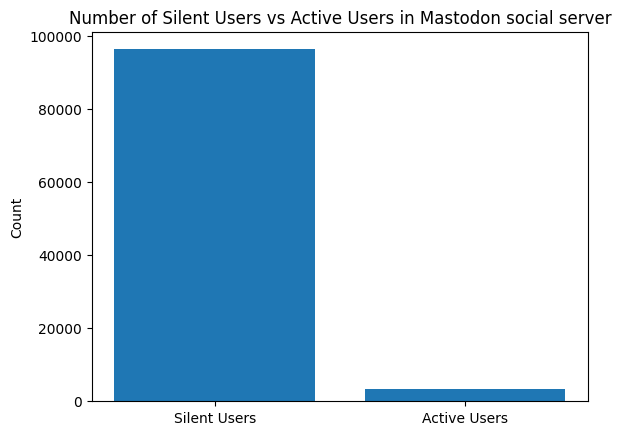

In [ ]:
# Plot the results as a bar chart
plt.bar(['Silent Users', 'Active Users'], [silent1, active1])
plt.title('Number of Silent Users vs Active Users in Mastodon social server')
plt.ylabel('Count')
plt.show()

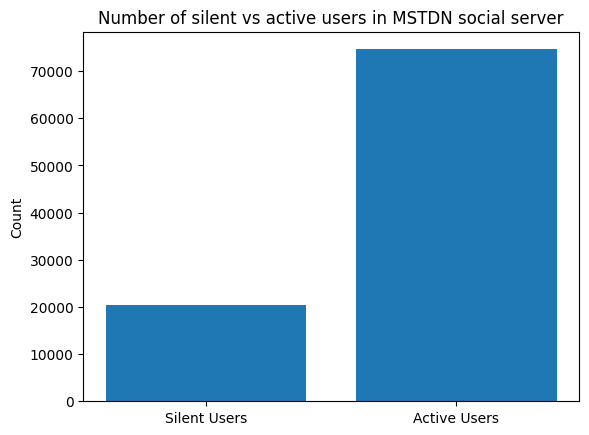

In [ ]:
# Plot the results as a bar chart
plt.bar(['Silent Users', 'Active Users'], [silent2, active2])
plt.title('Number of silent vs active users in MSTDN social server')
plt.ylabel('Count')
plt.show()

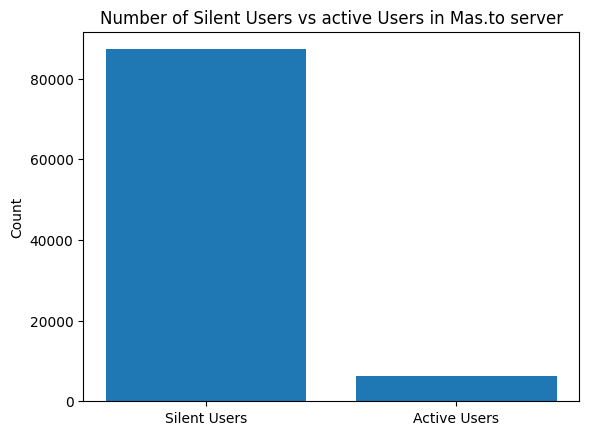

In [ ]:
# Plot the results as a bar chart
plt.bar(['Silent Users', 'Active Users'], [silent3, active3])
plt.title('Number of Silent Users vs active Users in Mas.to server')
plt.ylabel('Count')
plt.show()

In [ ]:
# Are users with more than average follower count more active or more silent?
#Plot status_cnt of users with more htan avg follower count vs days since creation time hue by label
follower_1

84.96578335471456

In [ ]:
following_1

44.08457945798589

In [ ]:
social_data.schema

StructType([StructField('statuses_count', IntegerType(), True), StructField('followers_count', IntegerType(), True), StructField('following_count', IntegerType(), True), StructField('daysSince', IntegerType(), True), StructField('daysSinceLastStatus', IntegerType(), True), StructField('tootpertime', IntegerType(), True), StructField('label', StringType(), False)])

In [ ]:
social_data.show(2,False)

+--------------+---------------+---------------+---------+-------------------+-----------+------+
|statuses_count|followers_count|following_count|daysSince|daysSinceLastStatus|tootpertime|label |
+--------------+---------------+---------------+---------+-------------------+-----------+------+
|1             |2              |2              |2555     |2676               |0          |Silent|
|100           |4              |0              |2554     |2676               |0          |Silent|
+--------------+---------------+---------------+---------+-------------------+-----------+------+
only showing top 2 rows



Silent: 8263 Active: 2785
2.9669658886894075


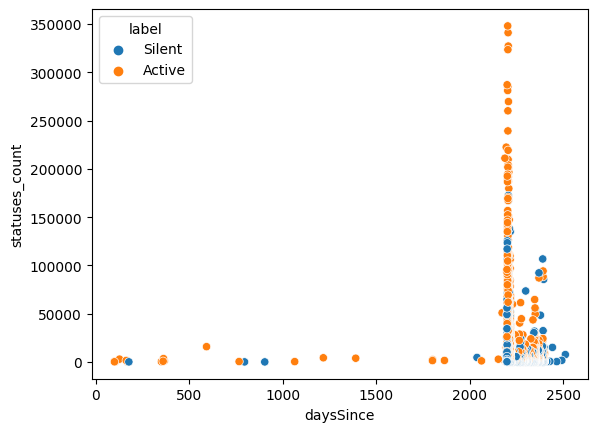

In [ ]:
# Are people with more than average following count more silent or more active?
def plot_popular_users(data, avg_follower_count,flag):
  popular_data = data[data['followers_count']>=avg_follower_count]
  if flag==1:
    popular_data = data[data['followers_count']<avg_follower_count]
  df = popular_data['daysSince', 'statuses_count','followers_count','label']
  silent_cnt = popular_data[popular_data['label']=='Silent'].count()
  active_cnt = popular_data[popular_data['label']=='Active'].count()
  print('Silent: %d Active: %d' %(silent_cnt, active_cnt))
  print(silent_cnt/active_cnt)
  created_dates = df.select("daysSince").rdd.flatMap(lambda x: x).collect()
  status_counts = df.select("statuses_count").rdd.flatMap(lambda x: x).collect()
  labels_lists = df.select("label").rdd.flatMap(lambda x: x).collect()
  df1 = pd.DataFrame({"daysSince": created_dates,
                   "statuses_count": status_counts,"label":labels_lists})
  g = sns.scatterplot(x="daysSince", y="statuses_count", hue='label', data=df1)
  # g = sns.lineplot(x="daysSince", y="tootpertime", hue='label', data=df1)
  # g.show()
plot_popular_users(social_data,follower_1,0)

Silent users are almost three times the active users count among the popular users ( users with following count greater than the average follower count in this server).

Silent: 88163 Active: 565
156.04070796460178


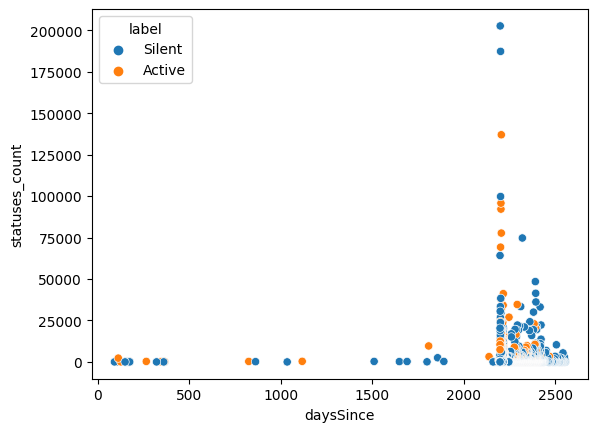

In [ ]:
# Are users with less than average following count more active or more silent?
plot_popular_users(social_data,follower_1,1)

Among the less popular users, there are 151 times more silent users than active users. <br/>
**Hence for Mastodon.social, we can say that the proportion of active users among the popular users is much greater than that in silent users group.**

Silent: 1153 Active: 537
2.1471135940409685


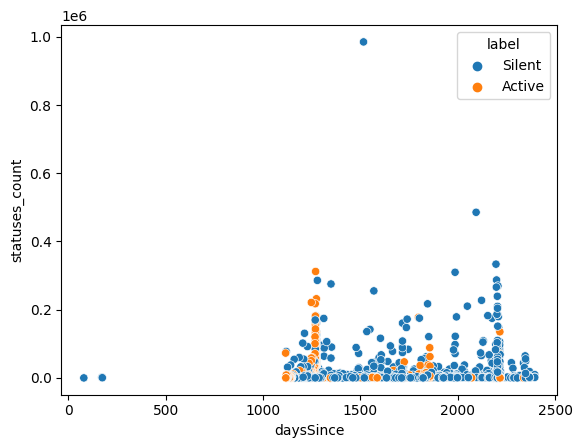

In [ ]:
plot_popular_users(mstdnsocial_data,follower_2,0)

Silent: 19157 Active: 74092
0.258556929223128


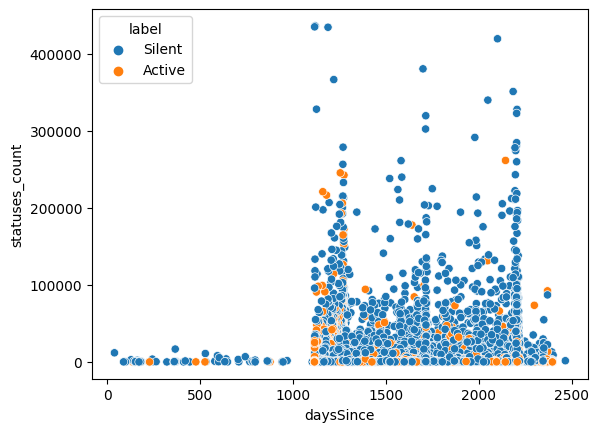

In [ ]:
plot_popular_users(mstdnsocial_data,follower_2,1)

Silent: 1772 Active: 750
2.3626666666666667


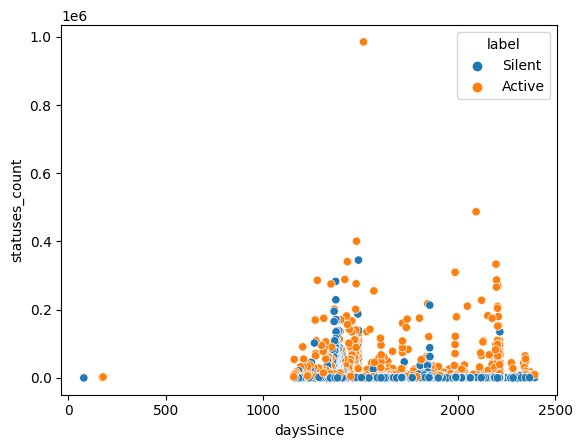

In [ ]:
plot_popular_users(masto_data,follower_3,0)

Silent: 85493 Active: 5413
15.794014409754295


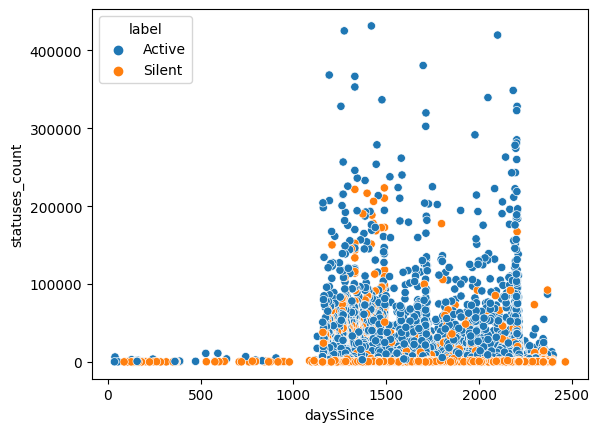

In [ ]:
plot_popular_users(masto_data,follower_3,1)

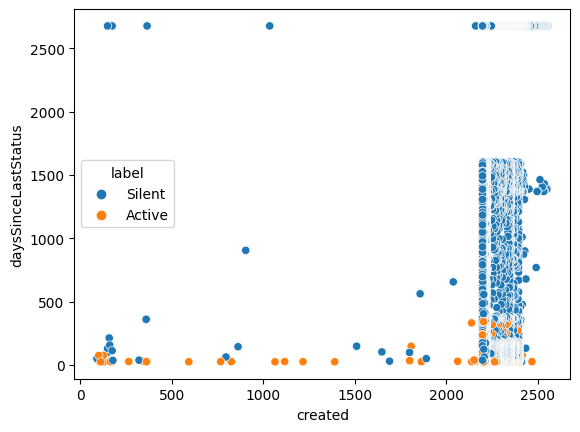

In [ ]:
# Are old users more active than new users?
def oldvsnew(data):
  df = data['daysSinceLastStatus', 'daysSince','label']
  last_status_days = df.select("daysSinceLastStatus").rdd.flatMap(lambda x: x).collect()
  created_dates = df.select("daysSince").rdd.flatMap(lambda x: x).collect()
  
  labels_lists = df.select("label").rdd.flatMap(lambda x: x).collect()
  df1 = pd.DataFrame({"created": created_dates,
                   "daysSinceLastStatus": last_status_days,"label":labels_lists})
  g = sns.scatterplot(x="created", y="daysSinceLastStatus", hue='label', data=df1)
  # g = sns.lineplot(x="daysSince", y="tootpertime", hue='label', data=df1)
  # g.show()
oldvsnew(social_data)

We can see that there are more active users than silent users among the new users, whereas among the old users there seems to be more silent users than active users for Mastodon social server.

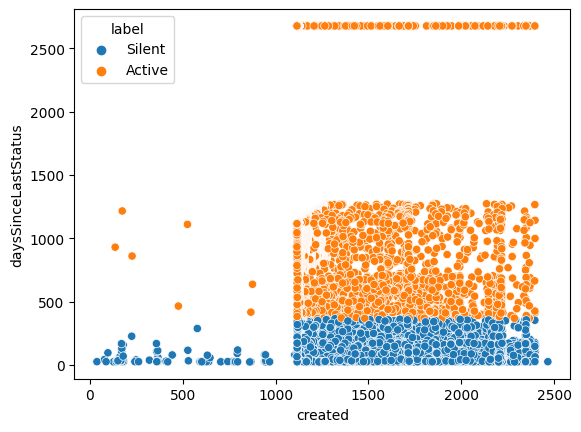

In [ ]:
oldvsnew(mstdnsocial_data)

Similar to what we observed in Mastodon.social, here in the mstdn.social too, more proportion of new users are active compared to the proportion of active old users

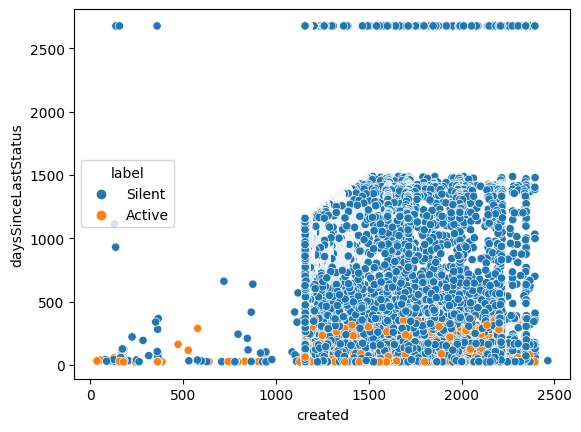

In [ ]:
oldvsnew(masto_data)

In Mas.to server, there are more silent users than any other server. In this server, the proportion of active users seems to be similar among both new and old users.

In [ ]:
social_data.count()

99776

In [ ]:
masto_data.count()

93428

In [ ]:
mstdnsocial_data.count()

94940

In [ ]:
def plot_tootpertime(data):
  df = data['daysSince', 'tootpertime','label']
  df = df.withColumn("tootpertime", df["tootpertime"].cast(IntegerType()))
  created_dates = df.select("daysSince").rdd.flatMap(lambda x: x).collect()
  status_counts = df.select("tootpertime").rdd.flatMap(lambda x: x).collect()
  labels_lists = df.select("label").rdd.flatMap(lambda x: x).collect()
  df1 = pd.DataFrame({"daysSince": created_dates,
                   "tootpertime": status_counts,"label":labels_lists})
  # g = sns.scatterplot(x="daysSince", y="tootpertime", hue='label', data=df1)
  g = sns.lineplot(x="daysSince", y="tootpertime", hue='label', data=df1)
  # g.show()

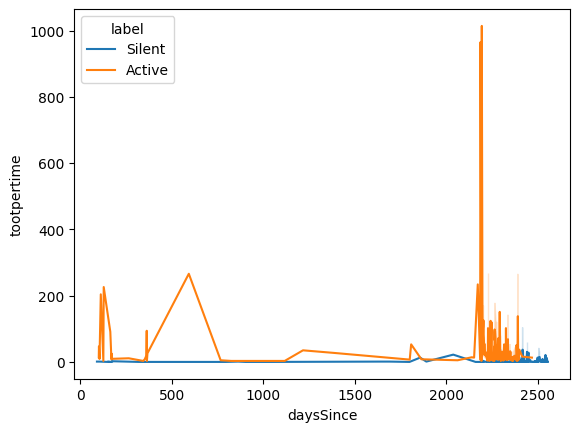

In [ ]:
plot_tootpertime(social_data)

 

*   From above plot, we can see that many silent users who joined early in Mastodon social server post regularly but post very limited number of posts.
*   There are more number of users who have been active since the creation of Mastodon server than the active users among recently joined users.



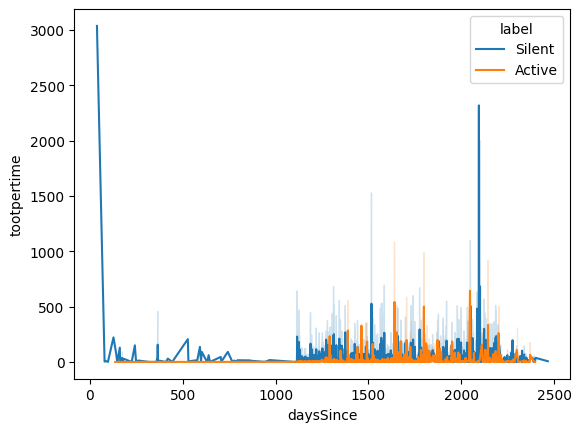

In [ ]:
plot_tootpertime(mstdnsocial_data)

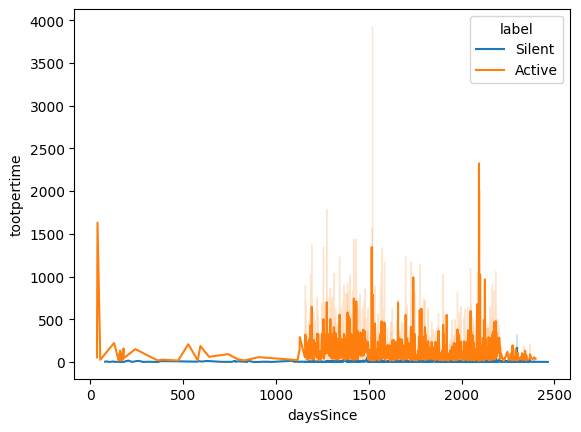

In [ ]:
plot_tootpertime(masto_data)

<div class="markdown-google-sans">
  <h2>5. Algorithms</h2>
</div>

We are using two algorithms, *CURE* and *Bisecting K-Means*, to test the performance of the user metrics:

*   *Average Statuses* denotes the average number of statuses since account creation to their last status. The last date of collection (April 5th) is utilized in the case that `last_status_at` is null. 

 That is, `statuses / (last_status_at - created_at)`.

*   *Engagement Ratio* denotes the difference between the engagement of an "active" user from a "silent" user. A weight of 2 is provided for `statuses` to indicate its importance.

 `(2 * df.statuses + 1) / (df.following + df.followers + 1))`



In [ ]:
def preprocess_data(file_path):
  df = spark.read.options(delimiter=",", inferSchema=True).csv(file_path)

  c0_split = split(df['_c0'], '\t')

  df = df.withColumn('_c0_0', c0_split.getItem(0))
  df = df.withColumn('_c0_1', c0_split.getItem(1))

  print(df.count(), 'in', file_path)

  df = df.drop('_c0')

  columns = ["silenced", "locked", "created_at", "last_status_at", "statuses", "followers", "following", "id", "bot"]

  for old, new in zip(df.columns, columns):
    df = df.withColumnRenamed(old, new)

  # The types of these two features were incorrectly inferred
  df = df.withColumn('created_at', df['created_at'].cast('Date'))
  df = df.withColumn('last_status_at', df['last_status_at'].cast('Date'))

  # Ignore all bots
  df = df.filter('bot == False')

  # The rows for these features are returning the same values
  df = df.drop('silenced', 'locked', 'bot')

  # only look at accounts that are atleast 30 days old
  reference_date = to_date(lit('2023-04-05'), 'yyyy-MM-dd')

  df = df.withColumn('account_age', datediff(reference_date, df.created_at))

  df = df.filter('account_age >= 30')

  # create two new features for the clustering of users
  last_status = coalesce(df.last_status_at, reference_date)
  days_since = datediff(last_status, df.created_at)

  df = df.withColumn('average_statuses', when(days_since > 0, df.statuses / days_since).otherwise(0))

  df = df.withColumn('engagement_ratio', (2 * df.statuses + 1) / (df.following + df.followers + 1))

  # select the two newly created features
  df = df.select('average_statuses', 'engagement_ratio').dropna()

  return df

In [ ]:
file_paths = ['user_data_1.txt', 'user_data_2.txt', 'user_data_3.txt', 'user_data_4.txt']

dataframes = [preprocess_data(file_path) for file_path in file_paths]

for i, df in enumerate(dataframes):
    print(f"First 5 rows of DataFrame {i + 1}:")
    print(df.count(), 'after filtering and cleaning')
    df.show(5)

100000 in user_data_1.txt
100000 in user_data_2.txt
100000 in user_data_3.txt
11004 in user_data_4.txt
First 5 rows of DataFrame 1:
99886 after filtering and cleaning
+--------------------+-------------------+
|    average_statuses|   engagement_ratio|
+--------------------+-------------------+
|  28.563325563325563|0.48040890869470043|
|   6.431287813310285| 121.99180327868852|
|0.005434782608695652|               14.5|
|  0.4361165048543689|              749.0|
|                 0.0|               0.25|
+--------------------+-------------------+
only showing top 5 rows

First 5 rows of DataFrame 2:
94946 after filtering and cleaning
+------------------+-------------------+
|  average_statuses|   engagement_ratio|
+------------------+-------------------+
|0.0723793677204659|0.03909740840035746|
|0.4842537654039252| 0.8495398159263705|
| 4.328066914498141|   8.74190520882215|
|0.7935278030993619|  1.992562929061785|
| 466.7927565392354| 191.41625412541254|
+------------------+---------

Constants that are utilized by the algorithms. The `SEED` is used by methods to generate the same sequences. `K_VALUES` represents the 2...18 or the values of k that are tested for each algorithm.

In [ ]:
SEED=1
K_VALUES = list(range(2, 20))

In [ ]:
def plot_scores(scores,title):
    plt.plot(K_VALUES, scores, marker='o')
    for a,b in zip(K_VALUES, scores): 
      plt.text(a, b, str(a))
    plt.xlabel('k')
    plt.ylabel('score')
    plt.title(title)
    plt.show()

In [ ]:
feature_names = ['average_statuses', 'engagement_ratio']

def scale_dataframe(df):
  # remove outliers from the dataset
  for feature in ['average_statuses', 'engagement_ratio']:
    percentiles = df.approxQuantile(feature, [0.01, 0.99], 0)
    df = df.filter((col(feature) >= percentiles[0]) & (col(feature) <= percentiles[1]))

  assembler = VectorAssembler(inputCols=feature_names, outputCol='features')

  scaler = MinMaxScaler(inputCol='features', outputCol='scaled')

  # Execute the tasks in stages
  pipeline = Pipeline(stages=[assembler, scaler])

  scaled_df = pipeline.fit(df).transform(df)

  return scaled_df

In [ ]:
tech_hub_df = dataframes[3]

scaled_df = scale_dataframe(tech_hub_df)

scaled_df.show()

+-------------------+--------------------+--------------------+--------------------+
|   average_statuses|    engagement_ratio|            features|              scaled|
+-------------------+--------------------+--------------------+--------------------+
|                0.0|                 0.5|           [0.0,0.5]|[0.0,1.6023147859...|
| 0.5387365911799762| 0.20939379916705228|[0.53873659117997...|[0.00340891026409...|
| 1.0771331058020477|  0.0901562098409344|[1.07713310580204...|[0.00681566865936...|
|   87.3215717722534|  1.4228937310117278|[87.3215717722534...|[0.55253607637645...|
| 28.563325563325563| 0.48054863820859234|[28.5633255633255...|[0.18073733116240...|
|0.11950394588500564|0.014377537212449255|[0.11950394588500...|[7.56173303236237...|
| 0.7767857142857143| 0.31413141314131415|[0.77678571428571...|[0.00491519016487...|
| 1.2902374670184698|               979.0|[1.29023746701846...|[0.00816410805659...|
|                0.0|  0.3333333333333333|[0.0,0.3333333333...|[0

In [ ]:
scaled_df = scaled_df.select('scaled')

@udf(returnType=DoubleType()) 
def v2s(vector):
  return float(vector[0])

for i, name in enumerate(feature_names):
  # split the scaled features into separate columns
  slicer = VectorSlicer(inputCol="scaled", outputCol=name, indices=[i])
  scaled_df = slicer.transform(scaled_df)

  # convert the vectors back into scalar values 
  scaled_df = scaled_df.withColumn(name, v2s(col(name)))

scaled_df.drop('scaled').show()

+--------------------+--------------------+
|    average_statuses|    engagement_ratio|
+--------------------+--------------------+
|                 0.0|1.602314785918634...|
|0.003408910264091181|6.547862140233128E-5|
|0.006815668659369667|2.660091596914150...|
|  0.5525360763764532|4.611432197901756...|
| 0.18073733116240123|1.538893148641780...|
| 7.56173303236237E-4|1.893095815962259...|
|0.004915190164878468|9.962857467528434E-5|
|0.008164108056593697|  0.3192025316573618|
|                 0.0|1.058894073640027...|
|                 0.0|0.001790493615427683|
|  0.0313783143212464|0.010590167569109027|
| 0.17829310295298226| 0.00913994511006712|
| 0.27920446390489734| 0.01850822055795013|
| 0.28938229176087543|0.019224956003142092|
|                 0.0|9.951984361271672E-4|
| 0.04201689745118685|0.015203996294671573|
|  0.6579243837316169|0.041406553355264546|
|0.017673644540538037|0.010810324069581887|
| 0.00254367985572886|4.422154383781883...|
|  0.0174540641573744|0.00436013

In [ ]:
scaled_df.count()

9486

The plot below is the result of scaling and removing outliers from the data. This shows that the majority of users have little to no "engagement" and have very few statuses (toots).

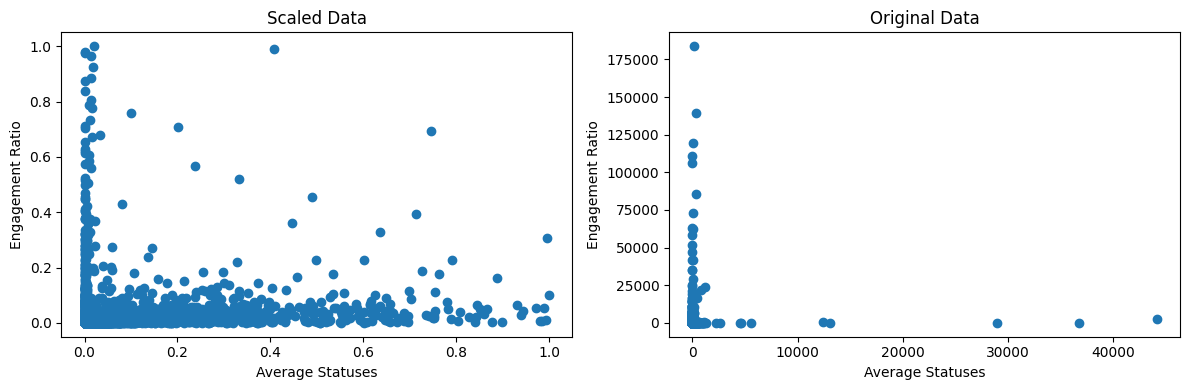

In [ ]:
scaled_pd = scaled_df.toPandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the scaled data
ax1.scatter(scaled_pd['average_statuses'], scaled_pd['engagement_ratio'])
ax1.set_xlabel("Average Statuses")
ax1.set_ylabel("Engagement Ratio")
ax1.set_title("Scaled Data")

tech_hub_pd = tech_hub_df.toPandas()

# Plot the original data
ax2.scatter(tech_hub_pd['average_statuses'], tech_hub_pd['engagement_ratio'])
ax2.set_xlabel("Average Statuses")
ax2.set_ylabel("Engagement Ratio")
ax2.set_title("Original Data")

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Perform a 80-20 split on the scaled data

train_df, test_df = scaled_df.randomSplit([0.8, 0.2], seed=SEED)

# Check for normality in data

In [ ]:
from scipy.stats import normaltest
# FINDING MAX VALUE IN A PYSPARK DATAFRAME COLUMN VALUES
# row1 = data.agg({"statuses_count": "max"}).collect()[0]
# print(row1["max(statuses_count)"])
# row1
def check_normality_on_dimension(data,dim):
  list_of_vals = data.select(f.collect_list(dim)).first()[0]
  # plt.hist(list_of_vals)
  # plt.show()
  # D'Agostino and Pearson's Test
  stat, p = normaltest(list_of_vals)
  print('Statistics=%.3f, p=%.3f' % (stat, p))
  # interpret
  alpha = 0.05
  if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
  else:
    print('Sample does not look Gaussian (reject H0)')

In [ ]:
check_normality_on_dimension(train_df,'average_statuses')

Statistics=7861.361, p=0.000
Sample does not look Gaussian (reject H0)


In [ ]:
check_normality_on_dimension(train_df,'engagement_ratio')

Statistics=12410.894, p=0.000
Sample does not look Gaussian (reject H0)


## Since data is not normal along each dimension, we cannot use BFR.

<div class="markdown-google-sans">
  <h2>CURE</h2>
</div>

This a hierarchical clustering algorithm that works by first selecting a small number of representative points from each cluster. These points are then used to find the closest pair of representatives from different clusters. The clusters that contain these closest pairs are then merged and this process is repeated until the desired number of clusters is met.

We drop the silent user label and then proceed to training with CURE algo

In [ ]:
from pyclustering.cluster import cure

# https://pyclustering.github.io/docs/0.8.2/html/dc/d6d/classpyclustering_1_1cluster_1_1cure_1_1cure.html
# convert the dataframe into a numpy array
train = np.array(train_df.rdd.map(lambda row: np.array(row['scaled'].toArray())).collect())
test = np.array(test_df.rdd.map(lambda row: np.array(row['scaled'].toArray())).collect())

c_s_scores = []
c_ch_scores = []

for k in range(2, 20):
  # train the 
  print("Training for k= %d" %k)  
  # cure.cure(data, num of clusters, num of representative points in each cluster, compression(hw close do we want
  # to move the representative points towards the centroid of the cluster))
  # We are taking the default 5 represntative points in each cluster and moving each of them 30% closer to centroid in each pass
  cure_instance = cure.cure(train, k,5,0.3)
  cure_instance.process()

  # Returns 3 lists with each list containing the indices of the row/user that belongs to that cluster
  clusters = cure_instance.get_clusters()
  if(k==3):
    print(clusters)
  # We chose 5 representative points in each cluster. Each point has 5 dimensions as each user is represented by
  # 5 features (statuses, followers, following,tootspertime, silent label) condensed in features col & scaled in
  # scaled column whom we pass to this algo. 
  # This code below returns 5 representative points with 5 dimensions for each of the k clusters. k X 5 X 5
  representative_points = cure_instance.get_representors()
  if(k==3):
    print(representative_points)
    print("Training ended for k: %d" %k)

  def nearest_representatives(point, representative_points):
    distances = [np.linalg.norm(point - rep_point) for rep_point in representative_points]
    return np.argmin(distances)

  # Picking the nearest representative point to each test data point.
  predictions = [nearest_representatives(point, representative_points) for point in test]

  num_labels = len(set(predictions))

  if num_labels > 1:
    silhouette = silhouette_score(test, predictions)

    c_s_scores.append(silhouette)

    calinski_harabasz = calinski_harabasz_score(test, predictions)
    
    c_ch_scores.append(calinski_harabasz)
  else:
    c_s_scores.append(None)
    c_ch_scores.append(None)

Training for k= 2
Training for k= 3
[[7578], [7486], [7332, 7442, 2104, 5269, 2103, 5556, 4840, 5408, 5301, 2105, 5225, 5687, 6970, 2098, 4735, 5300, 2099, 2100, 2101, 4960, 2096, 2097, 2095, 2102, 5045, 5494, 7285, 7573, 7574, 7582, 7595, 7588, 7590, 7589, 7591, 7592, 7594, 7593, 7584, 7585, 7587, 7586, 7579, 7580, 7577, 7581, 7576, 7583, 7544, 7545, 7543, 7540, 7541, 7537, 7539, 7542, 7532, 7533, 7534, 7536, 7535, 7538, 7530, 7531, 7548, 7550, 7555, 7546, 7553, 7556, 7558, 7561, 7547, 7551, 7552, 7554, 7559, 7565, 7566, 7568, 7562, 7567, 7571, 7572, 7569, 7570, 7564, 7563, 7557, 7501, 7505, 7502, 7507, 7510, 7509, 7512, 7508, 7516, 7519, 7518, 7520, 7523, 7517, 7525, 7527, 7524, 7521, 7522, 7511, 7513, 7514, 7515, 7503, 7504, 7506, 7526, 7528, 7481, 7494, 7467, 7439, 7549, 7529, 7596, 7597, 7598, 7599, 7601, 7600, 7602, 7604, 7560, 7575, 2091, 5047, 5768, 4550, 2092, 2093, 3770, 4376, 2094, 2078, 2079, 2076, 2077, 4599, 4833, 2080, 4402, 2084, 4076, 2085, 4138, 2081, 2082, 2083, 3988

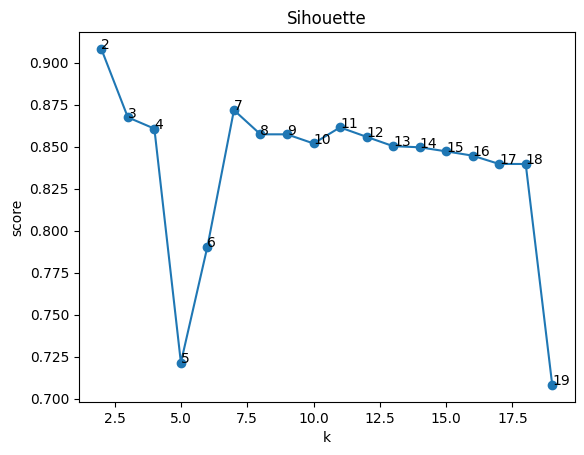

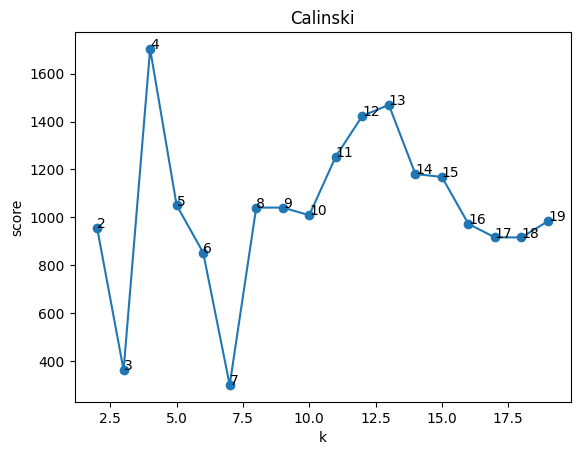

In [ ]:
plot_scores(c_s_scores, "Sihouette")
plot_scores(c_ch_scores, "Calinski")

We also get k=3 to be optimal after using CURE

<div class="markdown-google-sans">
  <h2>Hierarchical Clustering (Bisecting K-Means)</h2>
</div>

This is a hierarchical clustering algorithm that works by repeatedly splitting a cluster into two smaller clusters until the desired number of clusters is reached.

In [ ]:
from pyspark.ml.clustering import BisectingKMeans

hc_s_scores = []
hc_ch_scores = []

for k in range(2, 20):
  # Fit the model on the training data
  # Implementing Bisecting K-means clustering
  bisecting_kmeans = BisectingKMeans(k=k, featuresCol='scaled', seed=SEED)
  bisecting_kmeans_model = bisecting_kmeans.fit(scaled_df)

  # Predict the labels for the test data
  clustered_data = bisecting_kmeans_model.transform(test_df)

  # Evaluating the clustering results using the Silhouette score
  evaluator = ClusteringEvaluator(featuresCol="scaled", predictionCol="prediction")
  silhouette = evaluator.evaluate(clustered_data)

  hc_s_scores.append(silhouette)

  # Convert the PySpark dataframe to a Pandas dataframe
  pandas_df = clustered_data.select('scaled', 'prediction').toPandas()

  # Extract the feature matrix and labels from the Pandas dataframe
  features = np.array([x.toArray() for x in pandas_df['scaled']])
  labels = pandas_df['prediction'].to_numpy()

  # Compute the Calinski-Harabasz score using sklearn
  calinski_harabasz = calinski_harabasz_score(features, labels)

  hc_ch_scores.append(calinski_harabasz)

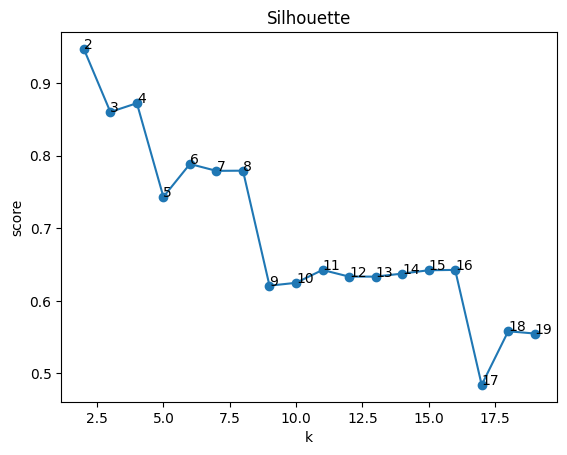

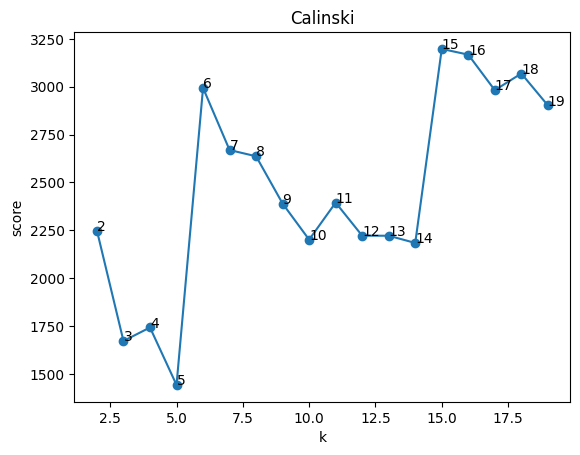

In [ ]:
plot_scores(hc_s_scores, "Silhouette")
plot_scores(hc_ch_scores, "Calinski")

Hierarchical clustering methods, Bisecting k-means gives us 3 as optimal num of clusters. 

<div class="markdown-google-sans">
  <h1>Results</h1>
</div>

We computed the silhouette and Calinski Harabasz scores for range of k values on the smallest dataset we collected for the techhub.social instance. In the next step, we analyze these findings further to get the best algorithm (which we'll use on the rest of the datasets).

In [ ]:
max_s = 0
flag=0
for each_c in c_s_scores:
  if each_c>max_s: 
    flag=1
    max_s = each_c
for each_c in hc_s_scores:
  if each_c>max_s: 
    flag=2
    max_s = each_c
max_s

0.9470932357934598

In [ ]:
max_ch = 0
flag1=0
for each_c in c_ch_scores:
  if each_c>max_ch: 
    flag1=1
    max_ch = each_c
for each_c in hc_ch_scores:
  if each_c>max_ch: 
    flag1=2
    max_ch = each_c
max_ch

3197.372793082106

Based on these scores, we can conclude that clusters in our data are dense and well separated. But both the indices yield high scores for convex shaped clusters. COmplexity of Silhouette is O(n2) but for Calinski is relatively faster to compute.

In [ ]:
best_k_s = 0
best_k_ch = 0
if flag==1:
  best_k_s = np.argmax(c_s_scores)+2
else:
  best_k_s = np.argmax(hc_s_scores)+2
if flag1==1:
  best_k_ch = np.argmax(c_ch_scores)+2
else:
  best_k_ch = np.argmax(hc_ch_scores)+2
flag

2

In [ ]:
flag1

2

In [ ]:
algorithms_s = 'CURE' if flag==1 else 'Bisecting'
algorithms_ch = 'CURE' if flag1==1 else 'Bisecting'

print('Best Silhouette Score:', algorithms_s, max_s , best_k_s )
print('Best Calinski-Harabasz Score:', algorithms_ch, max_ch, best_k_ch)

Best Silhouette Score: Bisecting 0.9470932357934598 2
Best Calinski-Harabasz Score: Bisecting 3197.372793082106 15


 

*   We found CURE performs better on our dataset wrt Silhouette score and  hierarchical clustering Bisecting k-means algorithm performs better wrt Calinski score.
*   Since we know the intended number of clusters in advance for our usecase,we will chose the algorithm based on its optimal k-values and apply the same algorithm on the remaining three datasets, which are Mastodon.scl, Mstdn.social, mas.tech.
*   CURE gets best results when there are 4 or 6 clusters, but we only need two clusters for our use case , whereas Bisecting k-means gets good clustering evaluator scores at  3 or 4 clusters. Since 3 or 4 clusters is more relevant to our usecase, we chose to go **forward with bisecting k-means** for the rest of our analysis.










In [ ]:
np.mean(hc_s_scores)

0.6913367577915799

In [ ]:
np.mean(hc_ch_scores)

2463.3433893007336

In [ ]:
# Merge the remaining dataframes
merged_df = dataframes[0].union(dataframes[1]).union(dataframes[2])

scaled_final_df = scale_dataframe(merged_df)

train_final_df, test_final_df = scaled_final_df.randomSplit([0.8, 0.2], seed=SEED)

scaled_final_df.count()

279704

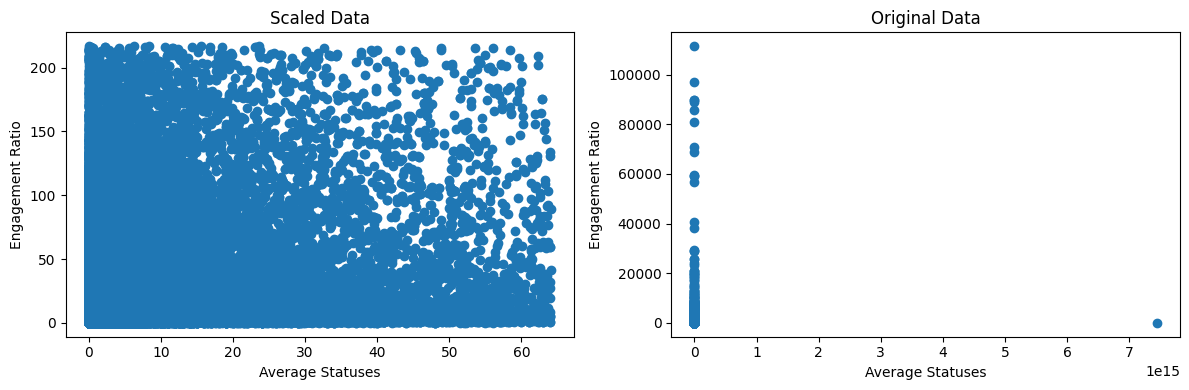

In [ ]:
scaled_final_pd = scaled_final_df.toPandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the scaled data
ax1.scatter(scaled_final_pd['average_statuses'], scaled_final_pd['engagement_ratio'])
ax1.set_xlabel("Average Statuses")
ax1.set_ylabel("Engagement Ratio")
ax1.set_title("Scaled Data")

merged_pd = merged_df.toPandas()

# Plot the original data
ax2.scatter(merged_pd['average_statuses'], merged_pd['engagement_ratio'])
ax2.set_xlabel("Average Statuses")
ax2.set_ylabel("Engagement Ratio")
ax2.set_title("Original Data")

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
check_normality_on_dimension(train_final_df,'engagement_ratio')

Statistics=243365.510, p=0.000
Sample does not look Gaussian (reject H0)


Using the parameters we obtained from our previous analysis and also using the same algorithm

In [ ]:
model_final1 = BisectingKMeans(k=2, featuresCol='scaled', seed=SEED)
model_final = model_final1.fit(train_final_df)

# Predict the labels for the test data
clustered_data_final = model_final.transform(test_final_df)

# Evaluating the clustering results using the Silhouette score
evaluator = ClusteringEvaluator(featuresCol="scaled", predictionCol="prediction")
silhouette = evaluator.evaluate(clustered_data_final)

# Convert the PySpark dataframe to a Pandas dataframe
final_pandas_df = clustered_data_final.select('scaled', 'prediction').toPandas()

# Extract the feature matrix and labels from the Pandas dataframe
features = np.array([x.toArray() for x in final_pandas_df['scaled']])
labels = final_pandas_df['prediction'].to_numpy()

# Compute the Calinski-Harabasz score using sklearn
calinski_harabasz = calinski_harabasz_score(features, labels)

print(silhouette, calinski_harabasz)

0.9415262317216182 56239.31297632077


Based on the scores, we can say that clusters are well defined and far from each other but the clusters are not dense.

The Silhouette score (0.9415262317216182) is near the maximum value of 1 suggests that the data points within a cluster are closer to each other and farther from points in other clusters.

A high Calinski-Harabasz score (56239.31297632077) indicates that the clusters well defined and separated separated from others.

**I'm reading that we may need to compare Calinski-Harabasz scores to other models, maybe we can say something about this for the initial test on the smaller sample**

In [ ]:
clustered_pd = clustered_data_final.toPandas()

In [ ]:
clustered_data_final.show()

+----------------+-------------------+--------------------+--------------------+----------+
|average_statuses|   engagement_ratio|            features|              scaled|prediction|
+----------------+-------------------+--------------------+--------------------+----------+
|             0.0|              0.025|         [0.0,0.025]|           (2,[],[])|         0|
|             0.0|              0.025|         [0.0,0.025]|           (2,[],[])|         0|
|             0.0|              0.025|         [0.0,0.025]|           (2,[],[])|         0|
|             0.0|              0.025|         [0.0,0.025]|           (2,[],[])|         0|
|             0.0|              0.025|         [0.0,0.025]|           (2,[],[])|         0|
|             0.0|0.02564102564102564|[0.0,0.0256410256...|[0.0,2.9569649238...|         0|
|             0.0|0.02564102564102564|[0.0,0.0256410256...|[0.0,2.9569649238...|         0|
|             0.0|0.02564102564102564|[0.0,0.0256410256...|[0.0,2.9569649238...|

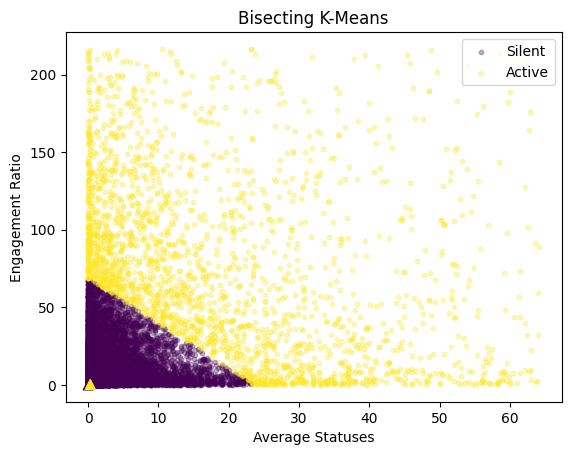

In [ ]:
cmap = plt.cm.viridis
colors = cmap([0.0, 1.0])

# Plot the predicted points
silent_users = clustered_pd[clustered_pd['prediction'] == 0]
active_users = clustered_pd[clustered_pd['prediction'] == 1]

plt.scatter(silent_users['average_statuses'], silent_users['engagement_ratio'], color=colors[0], s=10, alpha=0.3, label='Silent')
plt.scatter(active_users['average_statuses'], active_users['engagement_ratio'], color=colors[1], s=10, alpha=0.3, label='Active')


# Plot the centroids of each centroid
centroids = np.vstack(model_final.clusterCenters())

plt.scatter(centroids[:, 0], centroids[:, 1], marker='^', s=50, c=range(len(centroids)), cmap=cmap)

plt.legend()

# Label the axes with the corresponding feature
plt.xlabel("Average Statuses")
plt.ylabel("Engagement Ratio")
plt.title("Bisecting K-Means")

plt.show()

The predictions for the users from the accumulated test set show that ~96% of users are silent and ~4% are active.

Other sources have estimated between that 60-80 percentage of users are silent. The prediction for silent users is slightly higher than the thresholds listed in the sources below. This could be due to the clusters accounting for the users that contribute from time to time (as seen in the plot above). That is correct as we are considering silent users to be individuals with little to no contribution.

1. [Lurker demographics: counting the silent](https://dl.acm.org/doi/10.1145/332040.332409)
2. [The 90-9-1 Rule for Participation Inequality in Social Media and Online Communities](https://www.nngroup.com/articles/participation-inequality/)

In [ ]:
counts_df = clustered_data_final.groupBy('prediction').count()

counts_df = counts_df.withColumn('percentage', col('count') / clustered_data_final.count() * 100)

counts_df.show()

+----------+-----+-----------------+
|prediction|count|       percentage|
+----------+-----+-----------------+
|         1| 2352|4.207137107593239|
|         0|53553|95.79286289240676|
+----------+-----+-----------------+

